# EhV

# Package imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [4]:
import copy
import pickle

In [5]:
import numpy
import scipy.stats
from scipy.cluster.hierarchy import cut_tree

from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, robust_scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
from sklearn.preprocessing import scale, robust_scale, power_transform, normalize

import umap
import umap.plot

from matplotlib.colors import Normalize
from matplotlib.path import Path as mPath
from matplotlib.patches import Polygon

from kneed import KneeLocator
import optuna

In [6]:
from ehv.core import plot_gate_zarr_channels, SelectFromCollection
from ehv import normalization

In [7]:
import shap
shap.initjs()

In [8]:
import scanpy
import anndata

# Data import

In [9]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [10]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])
df = df[numpy.load(data_dir / "indices/columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "indices/iso.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(103775, 914)

In [11]:
with open(data_dir / "rfe/xgb_features.txt", "r") as fh:
    selected = [col[len("scip_"):] for col in fh.read().split(",")]

In [12]:
adata = anndata.AnnData(
    df.filter(regex="feat")[selected], 
    obs=pandas.concat([df.filter(regex="meta"), df.index.to_frame()], axis=1),
    dtype=numpy.float32
)
adata.raw = adata

# Dimensionality reduction

In [13]:
adata.X = adata.to_df().fillna(0)

In [14]:
adata.X = normalization.qq(adata.to_df(), (0.01, 0.99))

In [15]:
scanpy.tl.pca(adata)

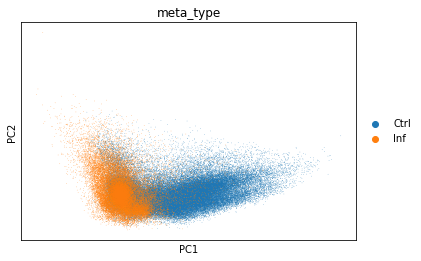

In [16]:
scanpy.pl.pca(adata, color="meta_type")

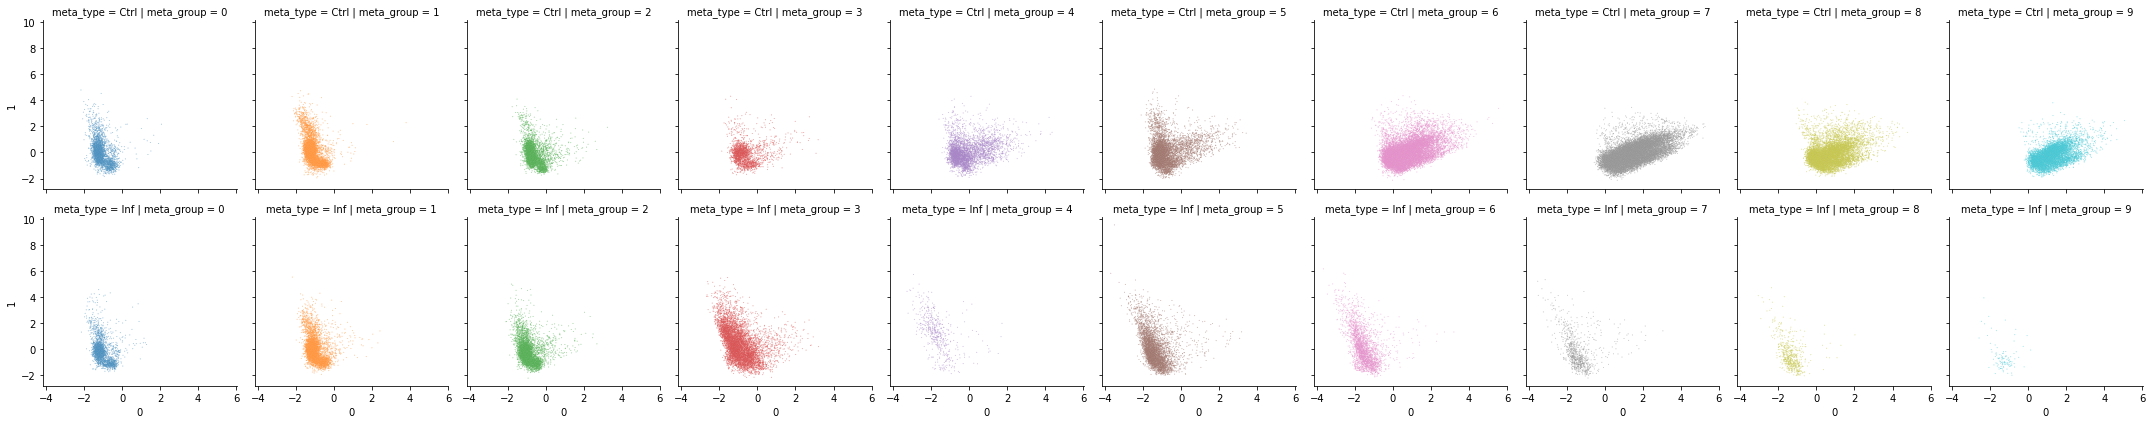

In [17]:
tmp_df = pandas.DataFrame(adata.obsm["X_pca"])
tmp_df.index = df.index
tmp_df["meta_label"] = df["meta_label"]

grid = seaborn.FacetGrid(data=tmp_df.reset_index(), row="meta_type", col="meta_group")
grid.map_dataframe(seaborn.scatterplot, x=0, y=1, hue="meta_group", s=1, alpha=0.5, edgecolors="none")

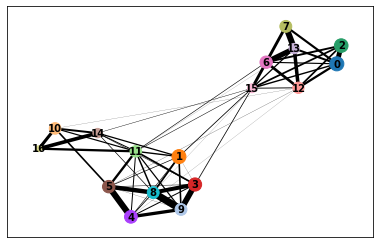

CPU times: user 2min 45s, sys: 416 ms, total: 2min 46s
Wall time: 2min 49s


In [18]:
%%time
scanpy.pp.neighbors(adata, n_neighbors=20)

scanpy.tl.louvain(adata)

scanpy.tl.paga(adata)
scanpy.pl.paga(adata)

scanpy.tl.umap(adata, min_dist=0.1, init_pos="paga")

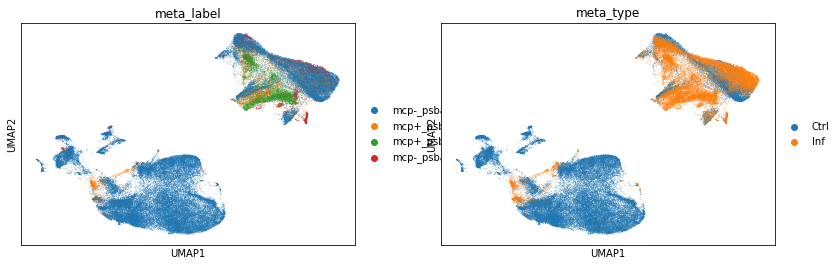

In [19]:
scanpy.pl.umap(adata, color=['meta_label', 'meta_type'])

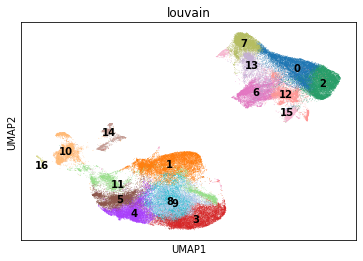

In [20]:
scanpy.pl.umap(adata, color='louvain', legend_loc='on data')

In [21]:
adata.obs["meta_label"].value_counts()

mcp-_psba+    86580
mcp+_psba-     7295
mcp-_psba-     5102
mcp+_psba+     4798
Name: meta_label, dtype: int64

## Major split along manifold

### Dendrogram

In [23]:
scanpy.tl.dendrogram(adata, groupby="louvain")
cut_map = cut_tree(adata.uns["dendrogram_louvain"]["linkage"], n_clusters=2).ravel()
adata.obs["louvain_dendro_2"] = adata.obs["louvain"].apply(lambda x: cut_map[int(x)])

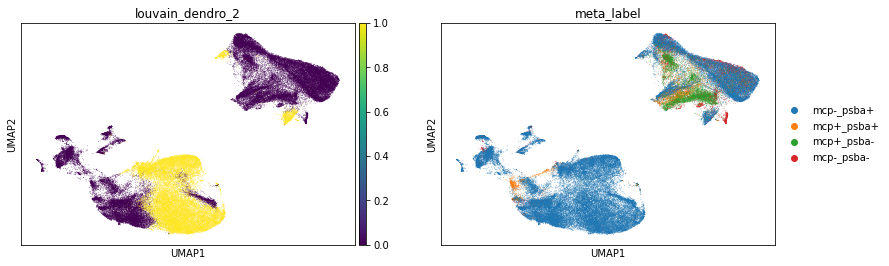

In [24]:
scanpy.pl.umap(adata, color=["louvain_dendro_2", "meta_label"])

In [37]:
scanpy.tl.dendrogram(adata, groupby="louvain")
cut_map = cut_tree(adata.uns["dendrogram_louvain"]["linkage"], n_clusters=3).ravel()
adata.obs["louvain_dendro_3"] = adata.obs["louvain"].apply(lambda x: cut_map[int(x)])

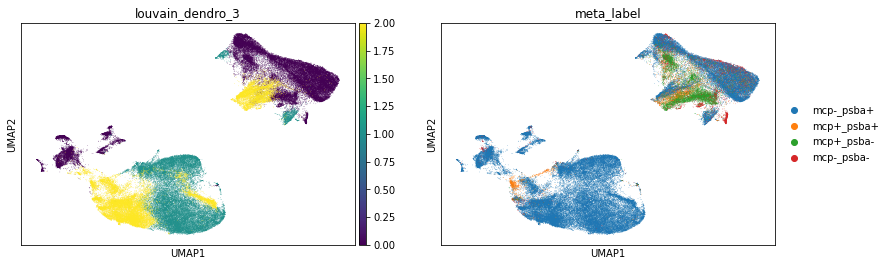

In [38]:
scanpy.pl.umap(adata, color=["louvain_dendro_3", "meta_label"])

### Manual assignment

In [25]:
inf_clust = [str(c) for c in [0,2,6,7,12,13,15]]
other_clust = [str(c) for c in [14,16,10,11,1,5,4,8,9,3]]

In [40]:
%%time

X = adata.X
target = adata.obs["louvain"].isin(inf_clust)

mi = mutual_info_classif(X, target, n_neighbors=20, random_state=0)
mi = pandas.Series(mi, index=selected).sort_values(ascending=False)
mi.head(n=20)

CPU times: user 1min 13s, sys: 51.1 ms, total: 1min 13s
Wall time: 1min 13s


feat_combined_mean_BF2                   0.615317
feat_mean_BF2                            0.603151
feat_combined_median_BF2                 0.579118
feat_combined_upper_quartile_BF2         0.576304
feat_combined_edge_lower_quartile_BF2    0.544973
feat_upper_quartile_BF2                  0.542056
feat_combined_lower_quartile_BF2         0.540276
feat_combined_edge_upper_quartile_BF2    0.533842
feat_edge_upper_quartile_BF2             0.476571
feat_sum_BF2                             0.224516
feat_area_BF1                            0.207194
feat_combined_bgcorr_sum_BF2             0.206397
feat_minor_axis_length_BF1               0.195140
feat_inertia_tensor_eigvals-1_BF1        0.195078
feat_combined_bgcorr_mean_BF2            0.192293
feat_combined_sum_SSC                    0.175395
feat_combined_edge_sum_SSC               0.170853
feat_edge_mean_DAPI                      0.163625
feat_edge_median_DAPI                    0.159768
feat_combined_bgcorr_sum_SSC             0.159187


<AxesSubplot:xlabel='value', ylabel='variable'>

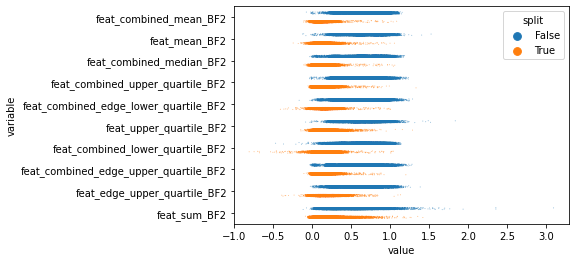

In [44]:
tmp_df = pandas.concat([adata.to_df(), adata.obs], axis=1)
tmp_df["split"] = target
seaborn.stripplot(data=pandas.melt(tmp_df.sample(n=50000), id_vars=["split"], value_vars=mi.head(n=10).index), hue="split", x="value", y="variable", dodge=True, s=1, alpha=.5)

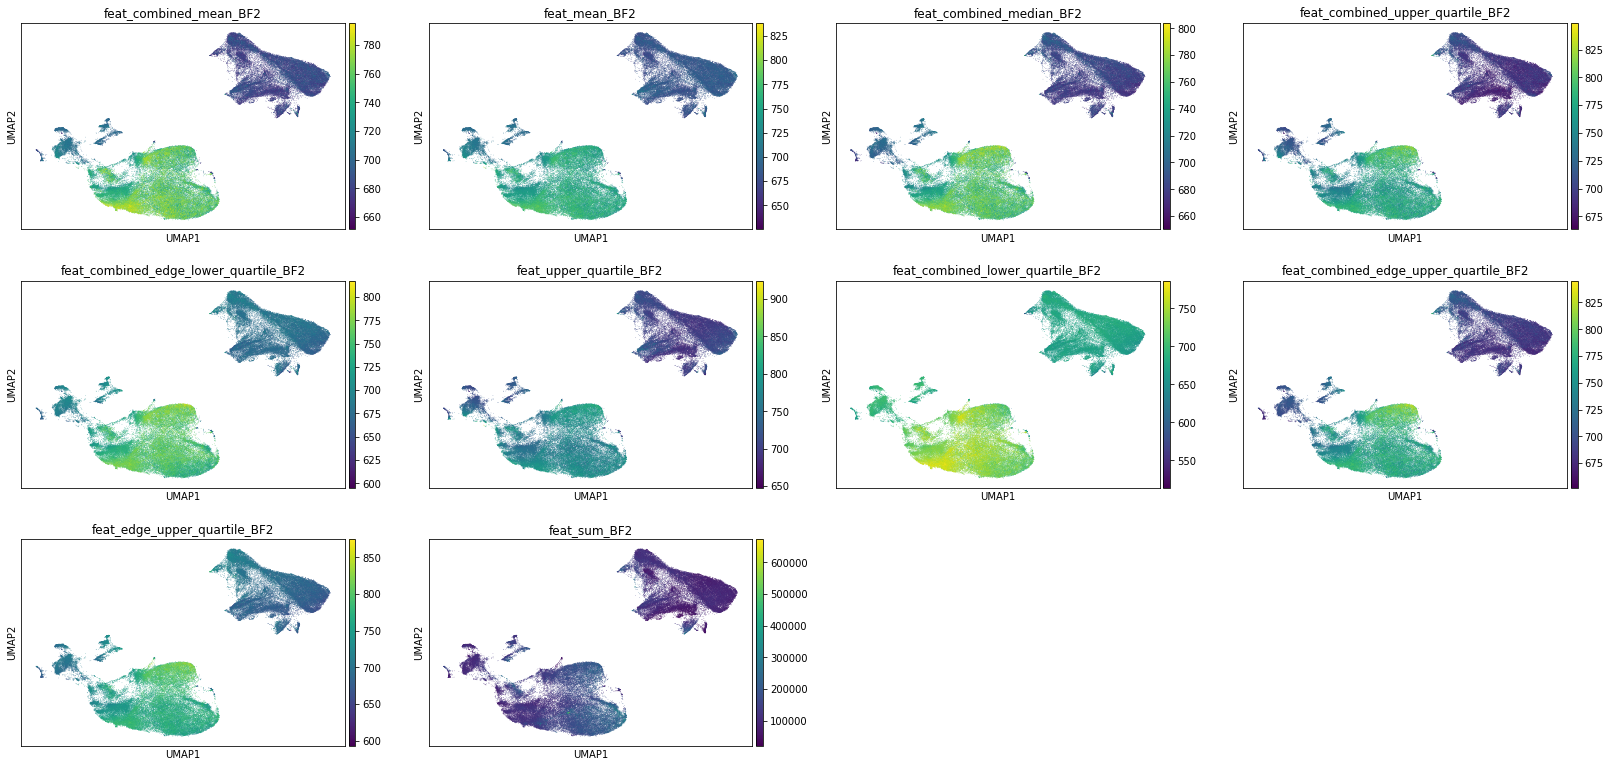

In [43]:
scanpy.pl.umap(adata, color=mi.head(n=10).index)

In [46]:
adata.obs["split"] = target

<AxesSubplot:xlabel='split', ylabel='feat_combined_mean_BF2'>

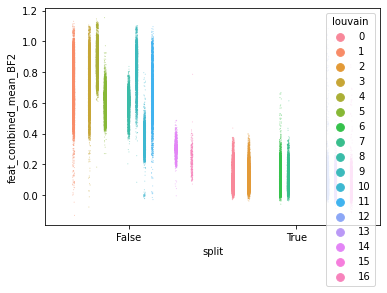

In [48]:
seaborn.stripplot(data=pandas.concat([adata.obs, adata.to_df()], axis=1), x="split", hue="louvain", y=mi.index[0], s=1, alpha=.5, dodge=True)

## Focusing on infection cycle clusters

In [49]:
sel1 = adata.obs["louvain"].isin(inf_clust)

In [50]:
adata2 = adata[sel1].copy()
adata2.shape

(44424, 111)

In [51]:
adata2.obs["meta_label"].value_counts()

mcp-_psba+    29086
mcp+_psba-     7226
mcp-_psba-     4444
mcp+_psba+     3668
Name: meta_label, dtype: int64

In [52]:
%%time
scanpy.tl.umap(adata2, min_dist=0.1)

CPU times: user 35.8 s, sys: 56.6 ms, total: 35.9 s
Wall time: 36 s


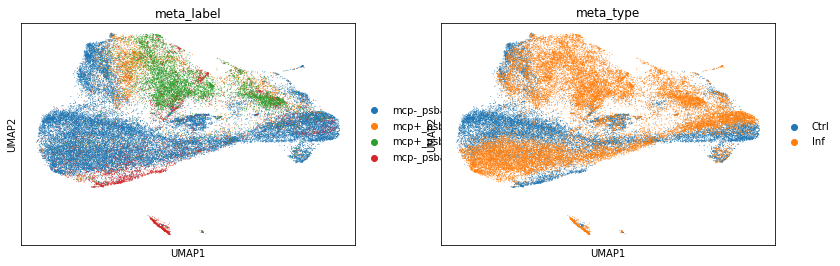

In [53]:
scanpy.pl.umap(adata2, color=['meta_label', 'meta_type'])

In [54]:
%%time
X = adata2.X
target = adata2.obs.index.get_level_values("meta_type")

mi = mutual_info_classif(X, target, discrete_features=False, n_neighbors=20, random_state=0)
mi = pandas.Series(mi, index=selected).sort_values(ascending=False)

CPU times: user 30.9 s, sys: 18.6 ms, total: 31 s
Wall time: 31.1 s


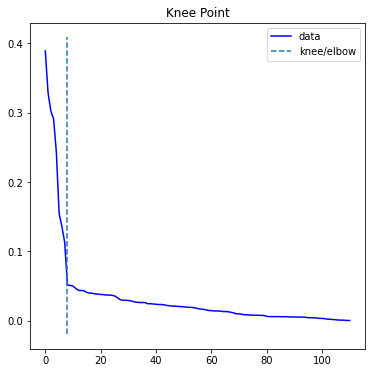

In [55]:
kneedle = KneeLocator(numpy.arange(len(mi)), mi, S=1, curve='convex', direction="decreasing",online=False)
elbow_value = mi.iloc[int(kneedle.knee)]

kneedle.plot_knee()

In [56]:
mi[mi > elbow_value].index.values

array(['feat_combined_mean_BF1', 'feat_mean_BF1',
       'feat_combined_edge_upper_quartile_BF1',
       'feat_combined_median_BF1', 'feat_combined_edge_median_BF1',
       'feat_combined_edge_lower_quartile_BF1',
       'feat_combined_lower_quartile_BF1', 'feat_edge_median_BF1'],
      dtype=object)

In [57]:
selected_mi = mi[mi < elbow_value].index.values
len(selected_mi)

102

In [58]:
def get_adata3():
    adata3 = adata2[:, selected_mi].copy()
    adata3 = anndata.AnnData(
        X=adata2[:, selected_mi].X, 
        obs=adata2[:, selected_mi].obs, 
        var=adata2[:, selected_mi].var,
        dtype=numpy.float64
    )
    adata3.raw = adata2[:, selected_mi]
    return adata3
adata3 = get_adata3()

In [111]:
adata_write = adata3.copy()
adata_write.obs = adata3.obs.reset_index(drop=True)
adata_write.write(str(data_dir / "anndata/cleaned.hda5"))
del adata_write

In [59]:
with open(data_dir / "optuna/purity.pickle", "rb") as fh:
    study = pickle.load(fh)

In [85]:
import hiplot
hiplot.Experiment.from_optuna(study).display()

<IPython.core.display.Javascript object>

In [60]:
study.best_trial

FrozenTrial(number=96, values=[-0.8215637489089764], datetime_start=datetime.datetime(2022, 4, 21, 14, 16, 9, 415814), datetime_complete=datetime.datetime(2022, 4, 21, 14, 17, 7, 151281), params={'n_comps': 80, 'n_neighbors': 35, 'method': 'gauss', 'resolution': 2.5, 'do_scale': True}, distributions={'n_comps': IntUniformDistribution(high=100, low=10, step=5), 'n_neighbors': IntUniformDistribution(high=50, low=5, step=5), 'method': CategoricalDistribution(choices=('umap', 'gauss')), 'resolution': DiscreteUniformDistribution(high=5.0, low=0.5, q=0.1), 'do_scale': CategoricalDistribution(choices=(True, False))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=96, state=TrialState.COMPLETE, value=None)

In [61]:
def louvain_cluster(ad, do_scale, n_comps, n_neighbors, method, resolution):
    if do_scale:
        scanpy.pp.scale(ad)
    
    if n_comps > 0:
        scanpy.pp.pca(ad, n_comps=n_comps)
        
    scanpy.pp.neighbors(ad, n_neighbors=n_neighbors, knn=True, method=method, n_pcs=n_comps)
    scanpy.tl.louvain(ad, resolution=resolution, random_state=0)

In [62]:
louvain_cluster(adata3, **study.best_trial.params)

In [63]:
scanpy.tl.paga(adata3, groups="louvain")
scanpy.pl.paga(adata3, plot=False, add_pos=True)

scanpy.tl.umap(adata3, min_dist=0.1, init_pos="paga")

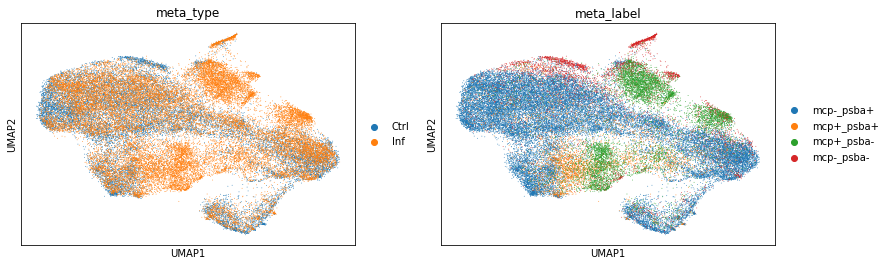

In [64]:
scanpy.pl.umap(adata3, color=["meta_type", "meta_label"])

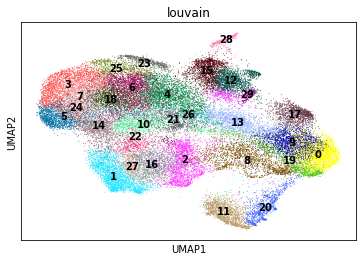

In [65]:
scanpy.pl.umap(adata3, color="louvain", legend_loc="on data")

In [66]:
"Purity: %.4f" % (adata3.obs.groupby(["louvain", "meta_label"]).size().groupby("louvain").max() / adata3.obs.groupby("louvain").size()).mean()

'Purity: 0.8158'

## Zooming in on structures

### Stationary cell clusters

In [76]:
sel_stationary = adata3.obs["louvain"].isin(["11", "20"])

In [78]:
%%time
mi2 = mutual_info_classif(adata3.X, sel_stationary, n_neighbors=10, random_state=0)
mi2 = pandas.Series(mi2, index=selected_mi).sort_values(ascending=False)
mi2.head(n=20)

CPU times: user 22.3 s, sys: 8.83 ms, total: 22.4 s
Wall time: 22.4 s


feat_combined_bgcorr_sum_SSC                    0.195288
feat_bgcorr_sum_SSC                             0.194194
feat_combined_sum_SSC                           0.193544
feat_sum_SSC                                    0.190371
feat_combined_bgcorr_edge_sum_SSC               0.187565
feat_combined_bgcorr_upper_quartile_SSC         0.185694
feat_combined_mad_SSC                           0.181377
feat_combined_median_SSC                        0.181072
feat_combined_edge_upper_quartile_SSC           0.180571
feat_combined_bgcorr_edge_upper_quartile_SSC    0.179581
feat_combined_edge_sum_SSC                      0.178136
feat_combined_bgcorr_median_SSC                 0.177479
feat_combined_edge_std_SSC                      0.175066
feat_combined_bgcorr_sum_BF1                    0.163253
feat_combined_bgcorr_edge_median_SSC            0.140042
feat_combined_bgcorr_sum_BF2                    0.125813
feat_combined_bgcorr_mean_BF2                   0.117524
feat_bgcorr_mean_BF1           

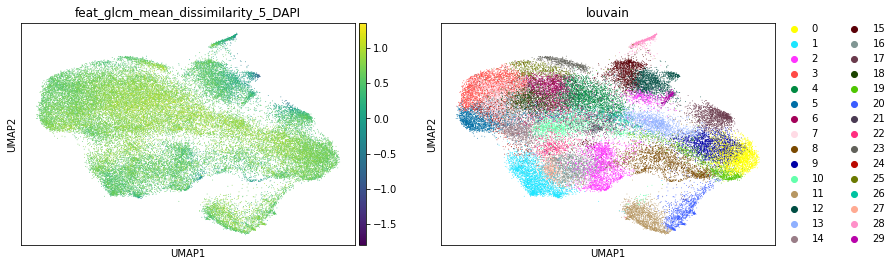

In [79]:
f = mi2.index.values[0]
qq = numpy.quantile(adata3[:, f].X, (0.05, 0.95))
scanpy.pl.umap(adata3, color=[f, "louvain"], vmin=qq[0], vmax=qq[1])

<AxesSubplot:xlabel='meta_type', ylabel='count'>

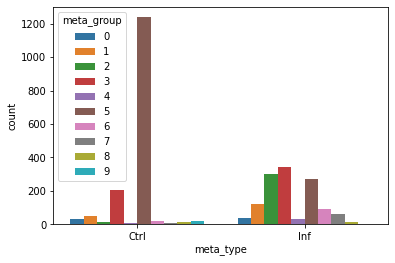

In [80]:
seaborn.countplot(data=adata3.obs[sel_stationary], x="meta_type", hue="meta_group")

### +/- structures

<AxesSubplot:xlabel='louvain'>

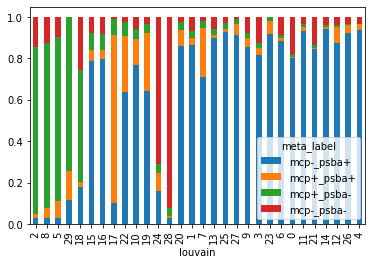

In [170]:
frac_df = (adata3.obs.groupby(["louvain", "meta_label"]).size() / adata3.obs.groupby("louvain").size()).to_frame(name="frac").reset_index()
frac_df.pivot(index="louvain", columns="meta_label", values="frac").sort_values("mcp+_psba-", ascending=False).plot.bar(stacked=True)

In [171]:
maj_df = frac_df[frac_df.frac > 0.6]
inf_clust = maj_df[maj_df["meta_label"] == "mcp+_psba-"]["louvain"].tolist()

adata3.obs["inf_clust"] = adata3.obs["louvain"].isin(inf_clust).astype(int)

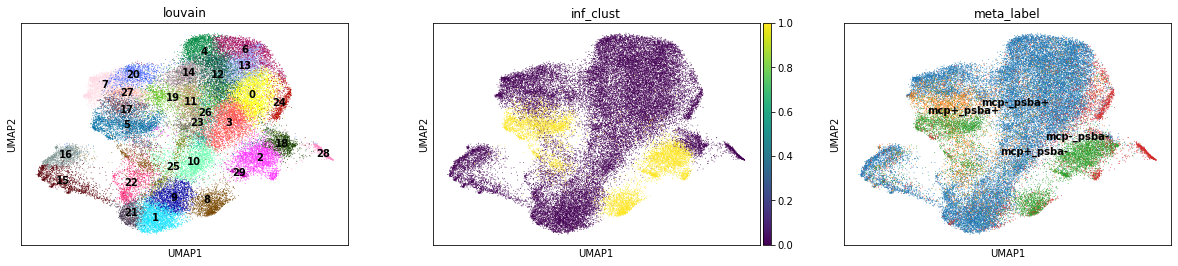

In [177]:
scanpy.pl.umap(adata3, color=["louvain", "inf_clust", "meta_label"], legend_loc="on data")

#### Explanations

In [192]:
X = adata3[adata3.obs["inf_clust"] > 0].X
y = adata3[adata3.obs["inf_clust"] > 0].obs["louvain"]

##### OVR SHAP

In [193]:
from sklearn.multiclass import OneVsRestClassifier

In [194]:
ovr = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=0)).fit(X, y)

In [198]:
numpy.random.seed(0)
explainer = shap.TreeExplainer(ovr.estimators_[0])
shap_values = explainer(adata3[adata3.obs["inf_clust"] > 0].to_df())

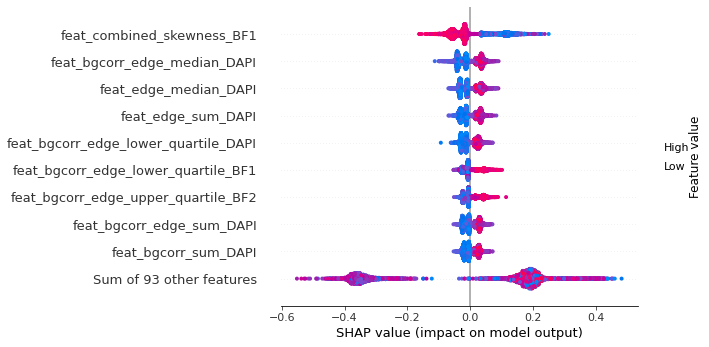

In [200]:
idx = numpy.argsort(shap_values[..., 0].abs.mean(axis=0).values)[::-1]
shap.plots.beeswarm(copy.deepcopy(shap_values[..., 0]), order=idx)

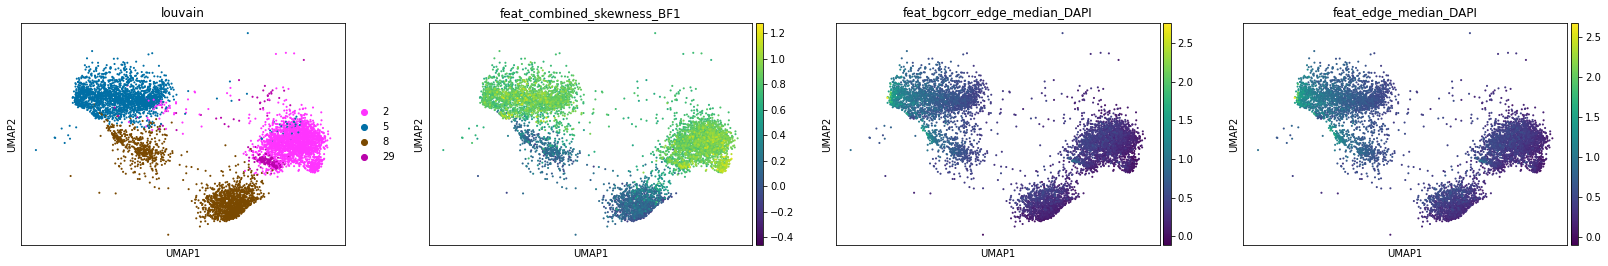

In [201]:
scanpy.pl.umap(adata3[adata3.obs["inf_clust"] > 0], color=["louvain"] + [adata3.var_names[i] for i in idx[:3]])

##### SHAP

In [181]:
rf = RandomForestClassifier(n_estimators = 100, oob_score=True).fit(X, y)
rf.oob_score_

0.9629844679924517

In [182]:
numpy.random.seed(0)
explainer = shap.TreeExplainer(rf)
shap_values = explainer(adata3[adata3.obs["inf_clust"] > 0].to_df())

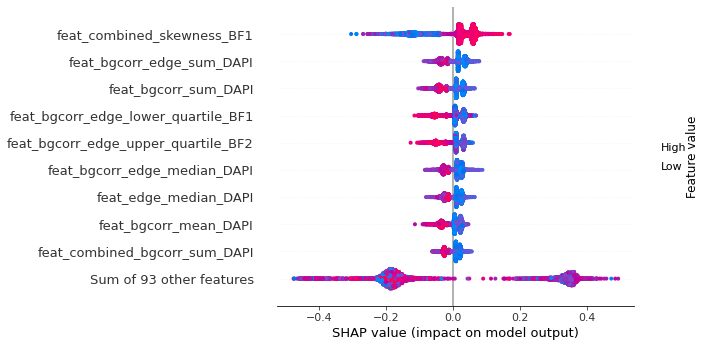

In [183]:
idx = numpy.argsort(shap_values[..., 0].abs.mean(axis=0).values)[::-1]
shap.plots.beeswarm(copy.deepcopy(shap_values[..., 0]), order=idx)

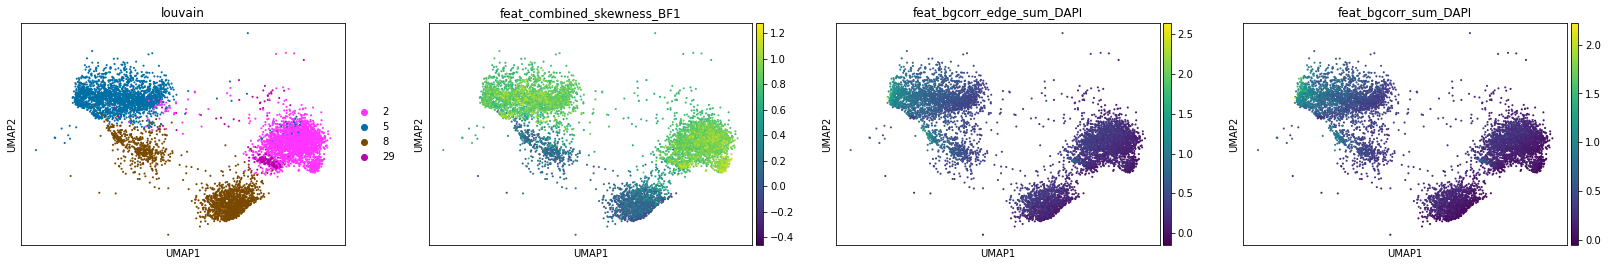

In [185]:
scanpy.pl.umap(adata3[adata3.obs["inf_clust"] > 0], color=["louvain"] + [adata3.var_names[i] for i in idx[:3]])

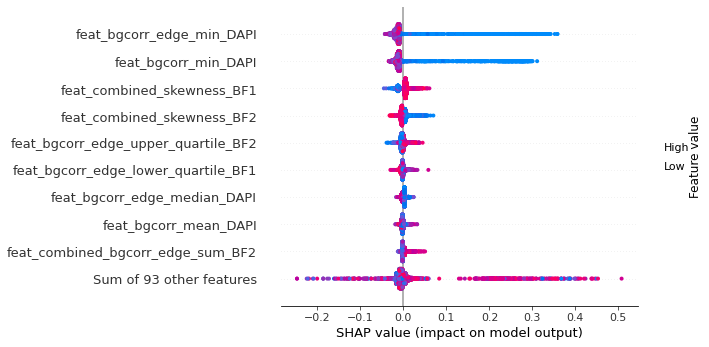

In [186]:
idx = numpy.argsort(shap_values[..., 1].abs.mean(axis=0).values)[::-1]
shap.plots.beeswarm(copy.deepcopy(shap_values[..., 1]), order=idx)

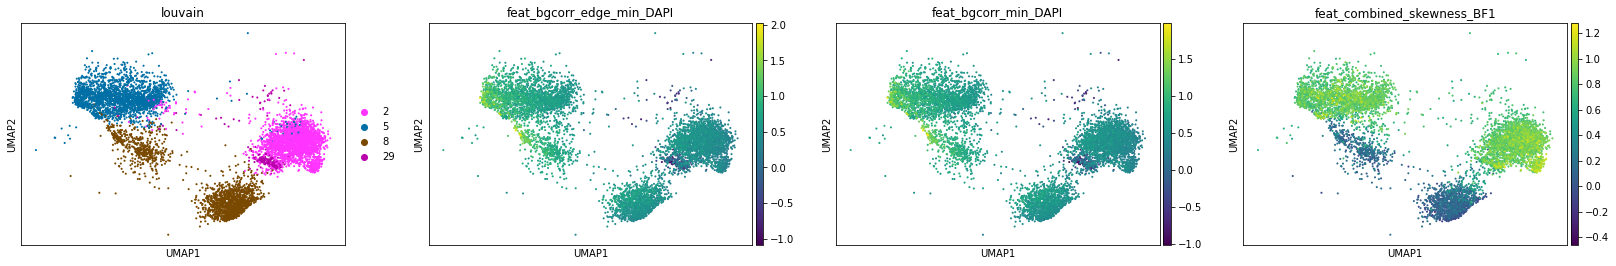

In [187]:
scanpy.pl.umap(adata3[adata3.obs["inf_clust"] > 0], color=["louvain"] + [adata3.var_names[i] for i in idx[:3]])

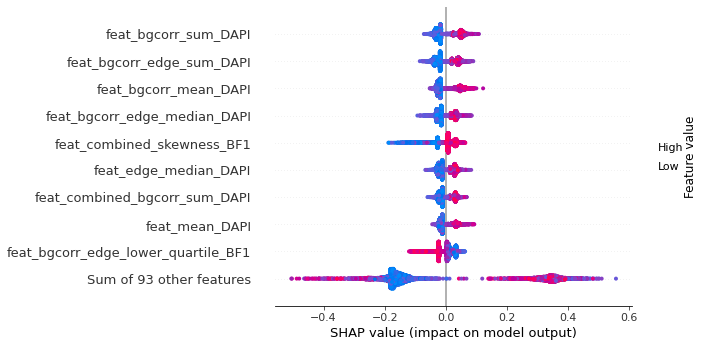

In [188]:
idx = numpy.argsort(shap_values[..., 2].abs.mean(axis=0).values)[::-1]
shap.plots.beeswarm(copy.deepcopy(shap_values[..., 2]), order=idx)

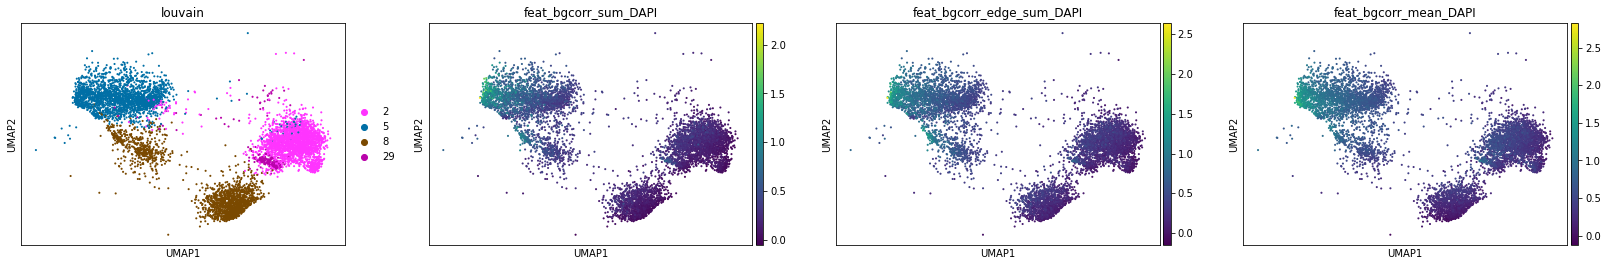

In [189]:
scanpy.pl.umap(adata3[adata3.obs["inf_clust"] > 0], color=["louvain"] + [adata3.var_names[i] for i in idx[:3]])

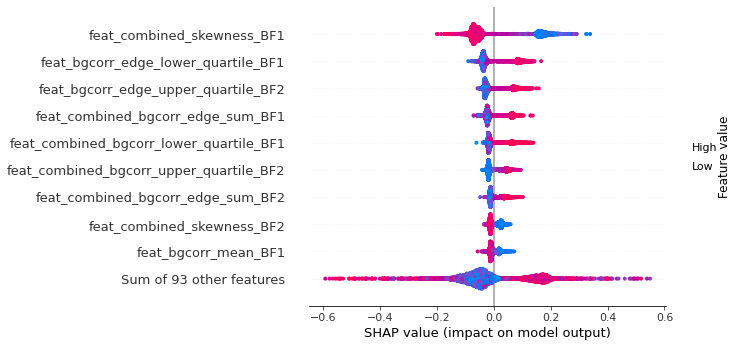

In [190]:
idx = numpy.argsort(shap_values[..., 3].abs.mean(axis=0).values)[::-1]
shap.plots.beeswarm(copy.deepcopy(shap_values[..., 3]), order=idx)

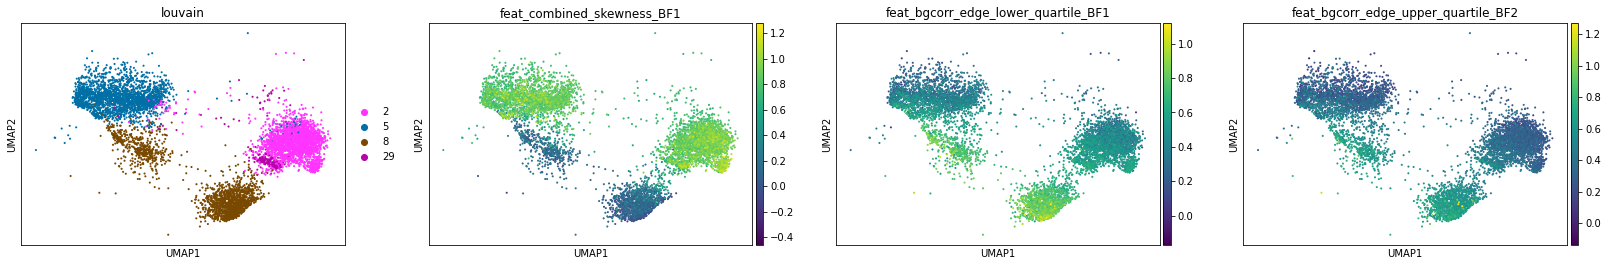

In [191]:
scanpy.pl.umap(adata3[adata3.obs["inf_clust"] > 0], color=["louvain"] + [adata3.var_names[i] for i in idx[:3]])

### Dead cells

<AxesSubplot:xlabel='louvain'>

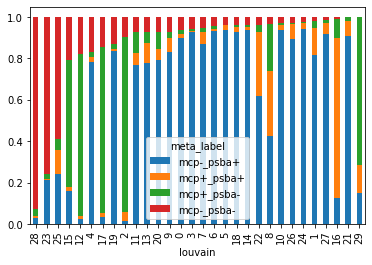

In [67]:
frac_df = (adata3.obs.groupby(["louvain", "meta_label"]).size() / adata3.obs.groupby("louvain").size()).to_frame(name="frac").reset_index()
frac_df.pivot(index="louvain", columns="meta_label", values="frac").sort_values("mcp-_psba-", ascending=False).plot.bar(stacked=True)

In [70]:
maj_df = frac_df[frac_df.frac > 0.5]
dead_clust = maj_df[maj_df["meta_label"] == "mcp-_psba-"]["louvain"].tolist()
adata3.obs["dead_clust"] = adata3.obs["louvain"].isin(dead_clust)

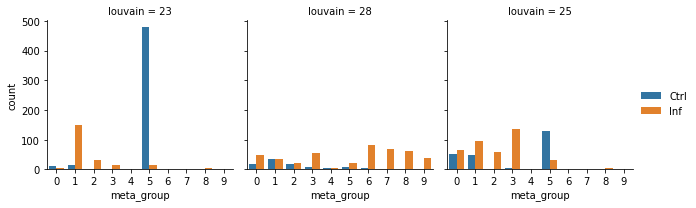

In [71]:
tmp_df = adata3.obs[adata3.obs["dead_clust"]].copy()
tmp_df["louvain"] = tmp_df["louvain"].astype(str)

grid = seaborn.FacetGrid(data=tmp_df, col="louvain")
grid.map_dataframe(seaborn.countplot, x="meta_group", hue="meta_type", palette="tab10")
grid.add_legend()

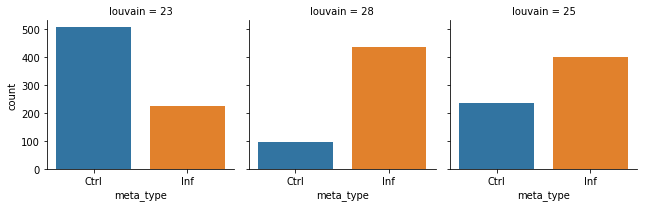

In [72]:
tmp_df = adata3.obs[adata3.obs["dead_clust"]].copy()
tmp_df["louvain"] = tmp_df["louvain"].astype(str)

grid = seaborn.FacetGrid(data=tmp_df, col="louvain")
grid.map_dataframe(seaborn.countplot, x="meta_type", palette="tab10")
grid.add_legend()

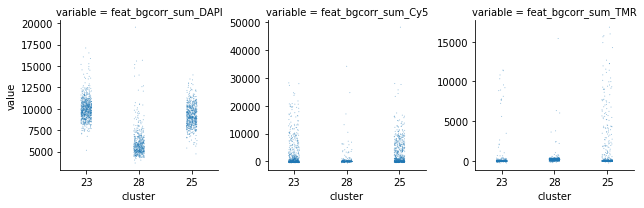

In [73]:
tmp_df = df.loc[adata3.obs.index[adata3.obs["dead_clust"]]][["feat_bgcorr_sum_DAPI", "feat_bgcorr_sum_Cy5", "feat_bgcorr_sum_TMR"]].copy()
tmp_df["cluster"] = adata3.obs[adata3.obs["dead_clust"]]["louvain"].astype(str)

tmp_df = pandas.melt(tmp_df, id_vars=["cluster"], value_vars=["feat_bgcorr_sum_DAPI", "feat_bgcorr_sum_Cy5", "feat_bgcorr_sum_TMR"])

grid = seaborn.FacetGrid(data=tmp_df, col="variable", sharey=False)
grid.map_dataframe(seaborn.stripplot, y="value", x="cluster", s=1, alpha=0.5, dodge=True)

### Cell cycle trajectory

<AxesSubplot:xlabel='louvain'>

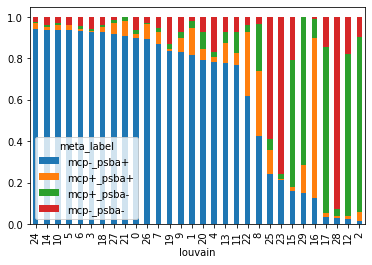

In [74]:
frac_df = (adata3.obs.groupby(["louvain", "meta_label"]).size() / adata3.obs.groupby("louvain").size()).to_frame(name="frac").reset_index()
frac_df.pivot(index="louvain", columns="meta_label", values="frac").sort_values("mcp-_psba+", ascending=False).plot.bar(stacked=True)

In [81]:
maj_df = frac_df[frac_df.frac > 0.5]
healthy_clust = maj_df[maj_df["meta_label"] == "mcp-_psba+"]["louvain"].tolist()

healthy_clust.remove("11")
healthy_clust.remove("20")

adata3.obs["healthy_clust"] = adata3.obs["louvain"].isin(healthy_clust).astype(int)

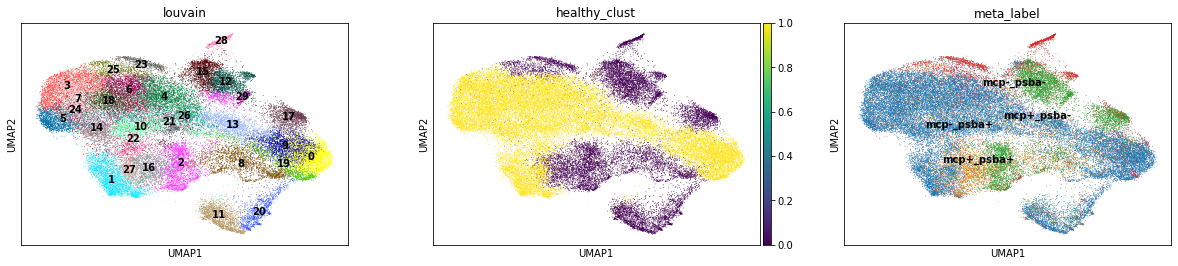

In [82]:
scanpy.pl.umap(adata3, color=["louvain", "healthy_clust", "meta_label"], legend_loc="on data")

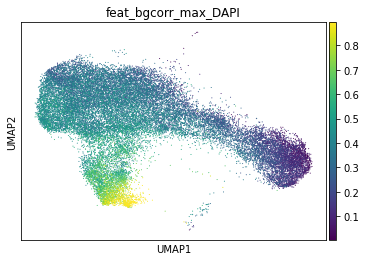

In [83]:
qq = numpy.quantile(adata3.raw[adata3.obs["healthy_clust"] == 1, "feat_bgcorr_max_DAPI"].X.ravel(), (0.01, 0.99))
scanpy.pl.umap(adata3[adata3.obs["healthy_clust"] == 1], color=["feat_bgcorr_max_DAPI"], vmin=qq[0], vmax=qq[1], use_raw=True)

## Export

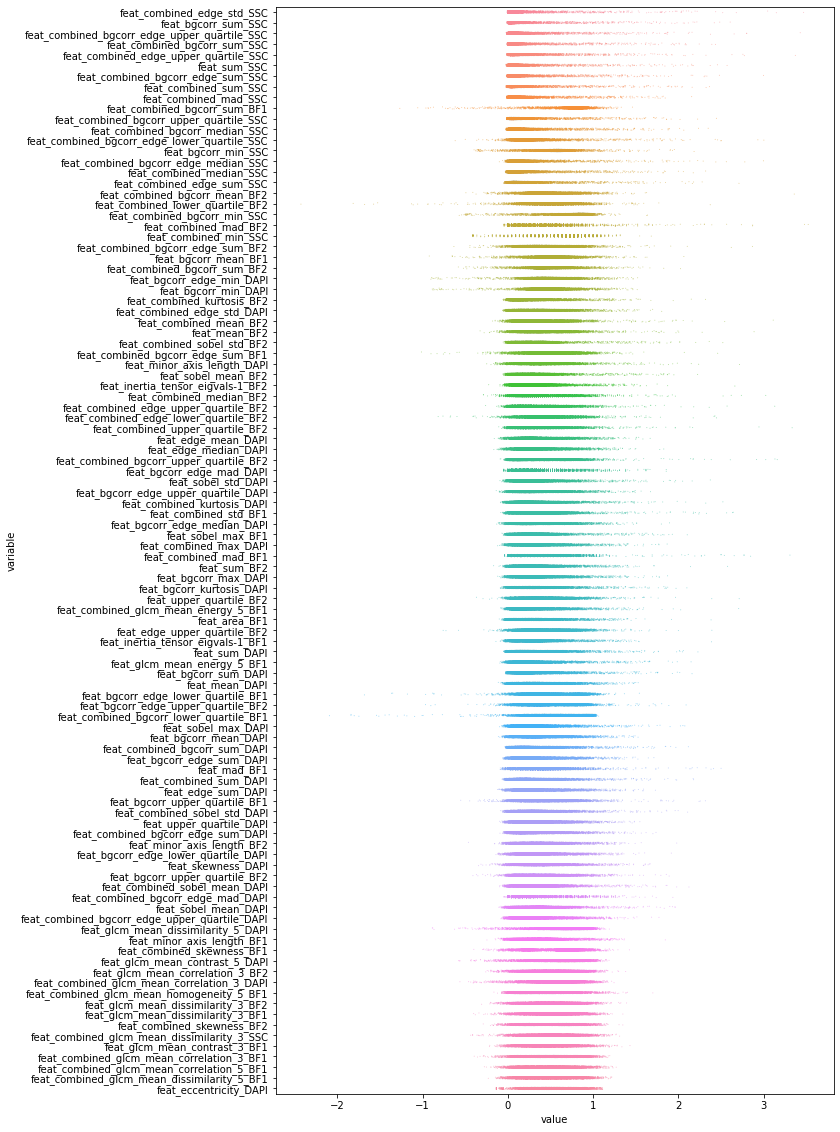

In [115]:
_ = normalization.dists(mm_df[selected_mi])

In [36]:
numpy.save(data_dir / "indices/cluster_index.npy", mm_df[selected_mi][~sel_stationary].index)

In [35]:
df.head()

meta_path  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                                                      
Ctrl      21766              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          19432              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          16719              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          19692              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          17745              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   

                                                                    meta_zarr_idx  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                  
Ctrl      21766              3              NaN         5                    1000   
          19432              3              NaN         5                    1001   
          16719              3              NaN         5                    1002   
          19692              3              NaN         5                    1003   
          17745              3              NaN         5                    1005   

                                                                    meta_bbox_minr  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                      3.0   
          19432              3              NaN         5                      3.0   
          16719              3              NaN         5                      1.0   
          19692              3              NaN         5                     12.0   
          17745              3              NaN         5                      0.0   

                                                                    meta_bbox_minc  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                      8.0   
          19432              3              NaN         5                      6.0   
          16719              3              NaN         5                     10.0   
          19692              3              NaN         5                      7.0   
          17745              3              NaN         5                      2.0   

                                                                    meta_bbox_maxr  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                     44.0   
          19432              3              NaN         5                     28.0   
          16719              3              NaN         5                     47.0   
          19692              3              NaN         5                     26.0   
          17745              3              NaN         5                     35.0   

                                                                    meta_bbox_maxc  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                     31.0   
          19432              3              NaN         5                     23.0   
          16719              3              NaN         5                     47.0   
          19692              3              NaN         5                     23.0   
          17745              3              NaN         5                     26.0   

                                                                    meta_regions_BF1  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                     
Ctrl      21766              3              NaN         5                   

In [116]:
# flowsom

out_df2 = mm_df[selected_mi][~sel_stationary].copy()
out_df2["meta_label"] = df["meta_label"]
out_df2.reset_index().to_feather(path=data_dir / "cells_scaled.feather")

In [117]:
%%time
pca = PCA(n_components=0.95).fit_transform(mm_df[selected_mi][~sel_stationary])

CPU times: user 454 ms, sys: 34.8 ms, total: 489 ms
Wall time: 491 ms


In [118]:
slingshot_df = pandas.DataFrame(
    data=numpy.hstack([pca, umap2_[~sel_stationary]]),
    columns=[f"pca_{i}" for i in range(len(pca.T))] + [f"umap_{i}" for i in range(len(umap2_.T))]
)

In [119]:
slingshot_df.to_feather(data_dir / "slingshot.feather")

## Plots

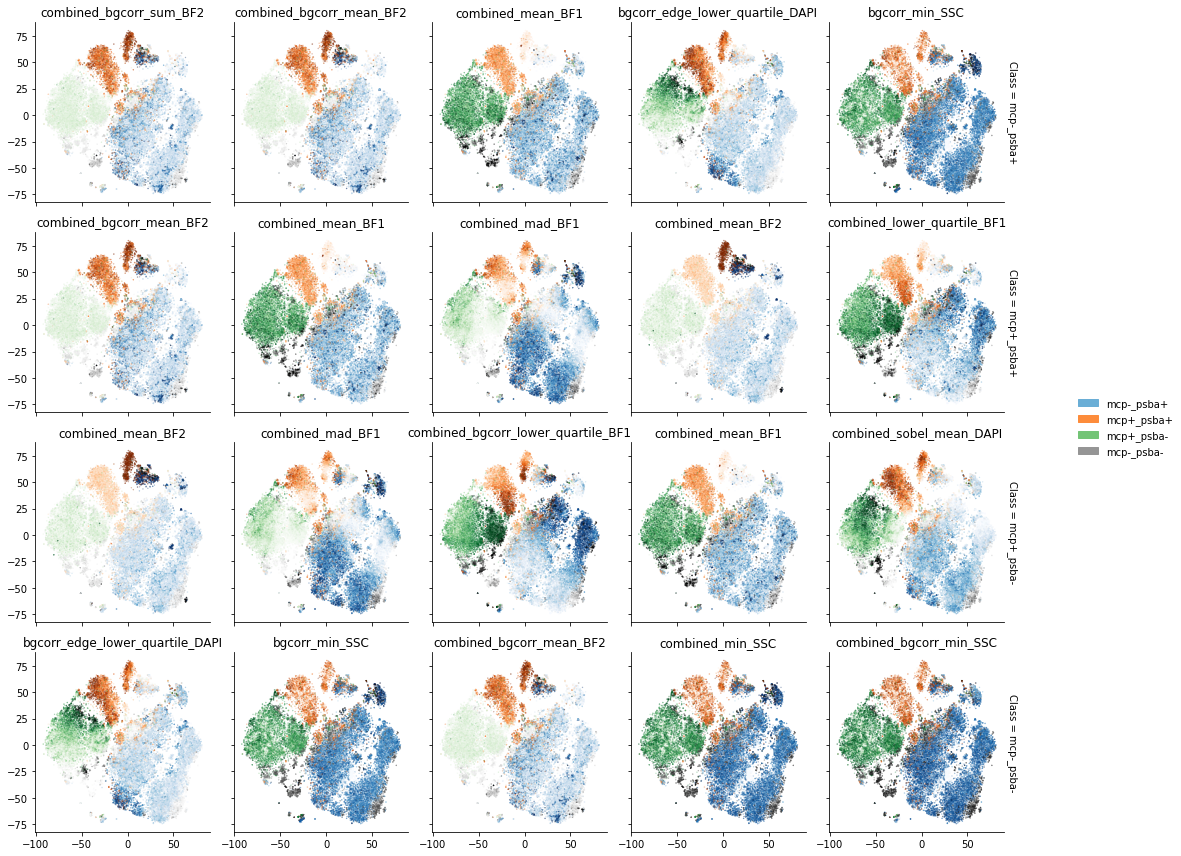

In [106]:
import matplotlib.patches as mpatches

def draw_dimred(data, x, *args, **kwargs):
    f = data[x].iloc[0][len("scip_"):]
    ax = plt.gca()
    norm = matplotlib.colors.Normalize(vmin=df.loc["Inf"][f].quantile(0.05), vmax=df.loc["Inf"][f].quantile(0.95))
    
    for cat, cmap in zip(df["meta_label"].cat.categories, ["Blues", "Oranges", "Greens", "Greys"]):
        sel = df.loc["Inf"]["meta_label"] == cat
        ax.scatter(x=tsne[sel, 0], y=tsne[sel, 1], cmap=cmap, norm=norm, c=df.loc["Inf"][sel][f], s=0.1, alpha=0.5)

grid = seaborn.FacetGrid(data=top5, row="Class", col="Rank", margin_titles=True)

legend_data = {}
for cat, cmap in zip(df["meta_label"].cat.categories, ["Blues", "Oranges", "Greens", "Greys"]):
    legend_data[cat] = mpatches.Patch(color=plt.get_cmap(cmap)(0.5), label=cat)
grid.add_legend(legend_data=legend_data)

grid.map_dataframe(draw_dimred, x="Feature")
for (c, r), ax in grid.axes_dict.items():
    f = top5.set_index(["Class", "Rank"]).loc[c, r]["Feature"]
    ax.set_title(f[len("scip_feat_"):])
    
grid.set_xlabels("")
grid.tight_layout()

plt.savefig(data_dir / "figures/tsne_color_top5_shap.png", bbox_inches="tight", dpi=150)

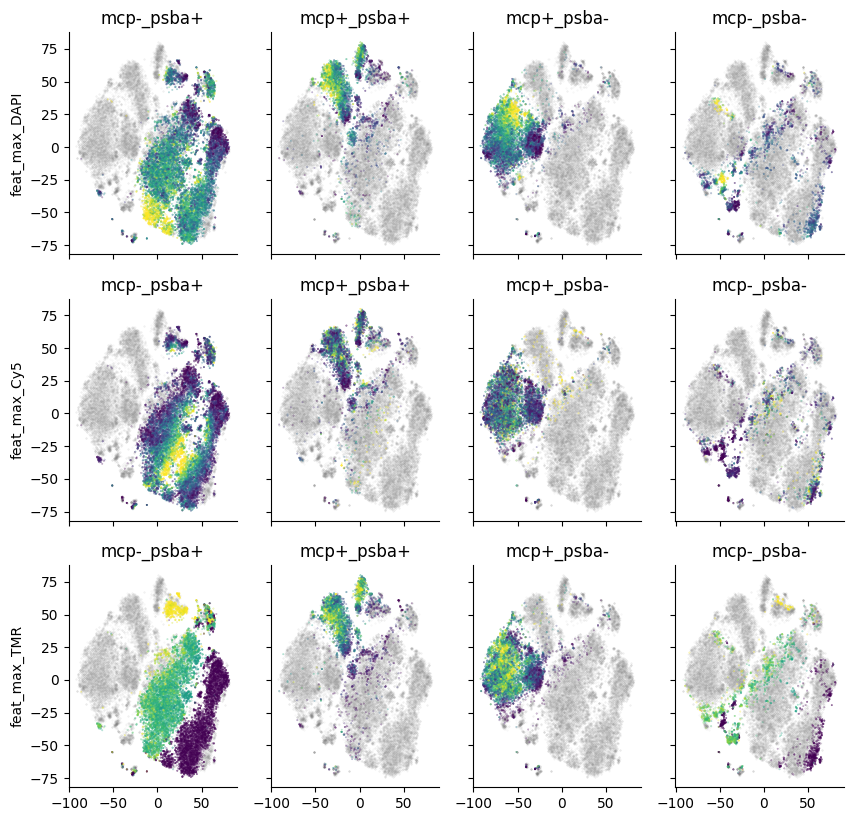

In [107]:
fig, axes = plt.subplots(3, 4, dpi=100, figsize=(10, 10), sharex=True, sharey=True)

for f, row in zip(["feat_max_DAPI", "feat_max_Cy5", "feat_max_TMR"], axes):

    row[0].set_ylabel(f)
    for ax, cat in zip(row, df["meta_label"].cat.categories):
        sel = df.loc["Inf"]["meta_label"] == cat
        norm = matplotlib.colors.Normalize(vmin=df.loc["Inf"][sel][f].quantile(0.05), vmax=df.loc["Inf"][sel][f].quantile(0.95))
        ax.scatter(x=tsne[~sel, 0], y=tsne[~sel, 1], c="grey", s=0.1, alpha=0.1)
        ax.scatter(x=tsne[sel, 0], y=tsne[sel, 1], cmap="viridis", norm=norm, c=df.loc["Inf"][sel][f], s=0.1, alpha=0.5)
        ax.set_title(cat)

seaborn.despine(fig)

plt.savefig(data_dir / "figures/tsne_color_fluor.png", bbox_inches="tight", dpi=150)